<a href="https://colab.research.google.com/github/ancestor9/24_fall_textmining_NLP/blob/main/Ch_11_CNN_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98%EB%A5%BC_%EC%9D%91%EC%9A%A9%ED%95%9C_%EB%AC%B8%EC%84%9C_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 12. CNN - 이미지 분류를 응용한 문서 분류

### **[자연어 처리를 위한 1D CNN(1D Convolutional Neural Networks)](https://wikidocs.net/80437)**

## 2. CNN을 이용한 문서 분류


### 2.1 NLTK 영화 리뷰 데이터 변환



In [ ]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [ ]:
from nltk.corpus import movie_reviews
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
#movie review data에서 file id를 가져옴
fileids = movie_reviews.fileids()
#file id를 이용해 raw text file을 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

np.random.seed(7)
tf.random.set_seed(7)

max_words = 1000 #사용할 단어의 수
maxlen = 100 #문서의 단어 수를 제한

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews) #만들어진 단어 인덱스를 이용해 변환
X = pad_sequences(X, maxlen=maxlen, truncating='pre')

# label을 0, 1의 값으로 변환
label_dict = {'pos':0, 'neg':1}
y = np.array([label_dict[c] for c in categories])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### 2.2 CNN 모형 생성 및 학습



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    #word embedding layer 생성
    Embedding(max_words, 64, input_length=maxlen),
    Conv1D(128, # 채널의 수
            5, # 1D 필터 크기
            padding='valid',
            activation='relu',
            strides=1),
    MaxPooling1D(),
    Conv1D(256, # 채널의 수
            5, # 1D 필터 크기
            padding='valid',
            activation='relu',
            strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2)

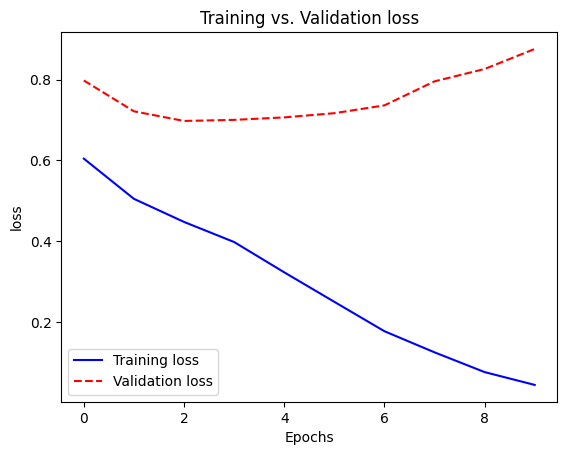

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5418 - loss: 0.9921
#Test accuracy:0.567


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'loss')

#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

### **이미지데이터**

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# 데이터 로드 및 전처리
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

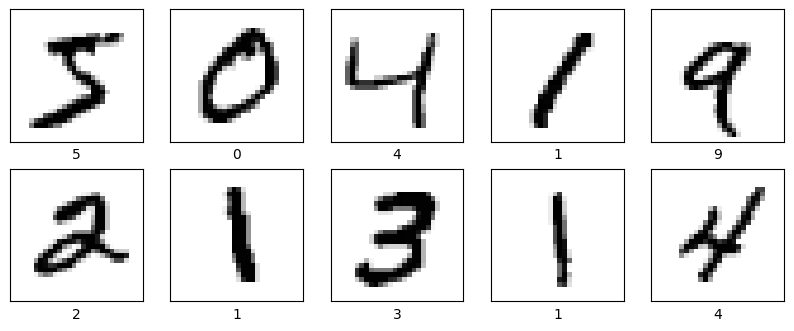

In [ ]:
# prompt: train_images 시각화 10개만 보여줘

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

In [ ]:
# 간단한 CNN 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # 합성곱 층
    layers.MaxPooling2D((2, 2)),  # 풀링 층
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),  # 평탄화 층
    layers.Dense(64, activation='relu'),  # 완전 연결 층
    layers.Dense(10, activation='softmax')  # 출력 층
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(train_images, train_labels, epochs=2, validation_data=(test_images, test_labels))

# 모델 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.9835 - loss: 0.0528 - val_accuracy: 0.9876 - val_loss: 0.0366
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9902 - loss: 0.0326 - val_accuracy: 0.9879 - val_loss: 0.0359
313/313 - 2s - 7ms/step - accuracy: 0.9879 - loss: 0.0359
Test accuracy: 0.9879000186920166


### **이미지데이터 예측에 적합한 CNN과 치원의 저주에 약한 KNN 비교**

In [ ]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train.max()

9

In [ ]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

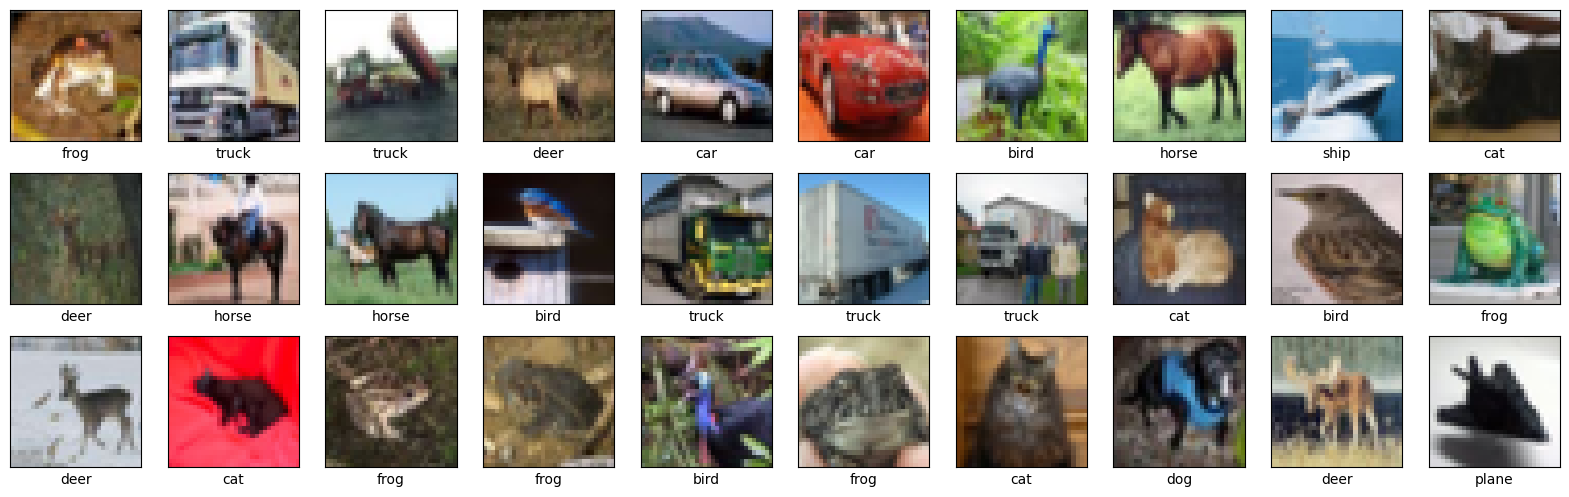

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # CIFAR-10 images are 32x32 with 3 color channels. No need to reshape.
    plt.imshow(X_train[i], cmap=plt.cm.viridis)  # Use a colormap suitable for color images. 'viridis' is a good default.
    plt.xlabel(classes[y_train[i][0]]) # Get the class label from y_train and classes
plt.show()

In [ ]:
# prompt: knn으로 학습하려 예측해줘

import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Reshape X_train and X_test to 2D arrays before fitting the model
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Create and train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_reshaped, y_train) # Use the reshaped data

# Make predictions on the test set using reshaped data
y_pred = knn.predict(X_test_reshaped)

# Evaluate the model (example using accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Accuracy: 0.3398


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.3400 - loss: 1.7796 - val_accuracy: 0.5652 - val_loss: 1.2295
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.5722 - loss: 1.1979 - val_accuracy: 0.6208 - val_loss: 1.0730
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.6408 - loss: 1.0220 - val_accuracy: 0.6544 - val_loss: 0.9998
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.6758 - loss: 0.9173 - val_accuracy: 0.6676 - val_loss: 0.9678
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.7077 - loss: 0.8401 - val_accuracy: 0.6773 - val_loss: 0.9576
313/313 - 3s - 11ms/step - accuracy: 0.6773 - loss: 0.9576


0.677299976348877

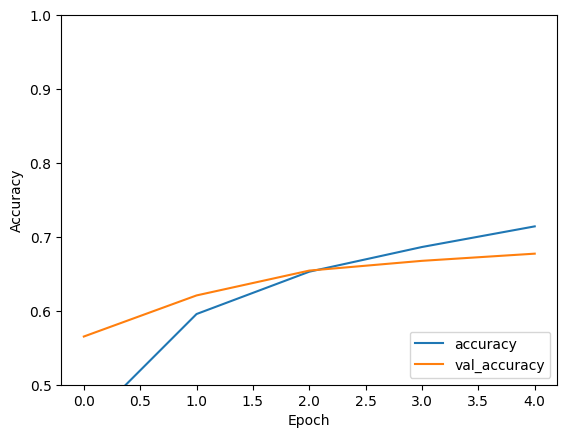

In [ ]:
# prompt: CNN으로 (X_train, y_train), (X_test, y_test) = cifar10.load_data()를 예측해줘

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_test, y_test))

# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
test_acc